# **메모리 구조**

- PGA =Program Global Area = 서버 프로세스에게 할당되는 메모리
  - 용도 : 유저로부터 요청받은 작업을 처리하는 데 사용되는 메모리 영역
- SGA = System Global Area = 프로세스 전체 간 공유되는 메모리
  - 용도 : 데이터를 디스크로부터 읽어 메모리로 적재한 후 Read/Write/Update/Delete 하는데 활용할 때 사용되는 메모리 공간


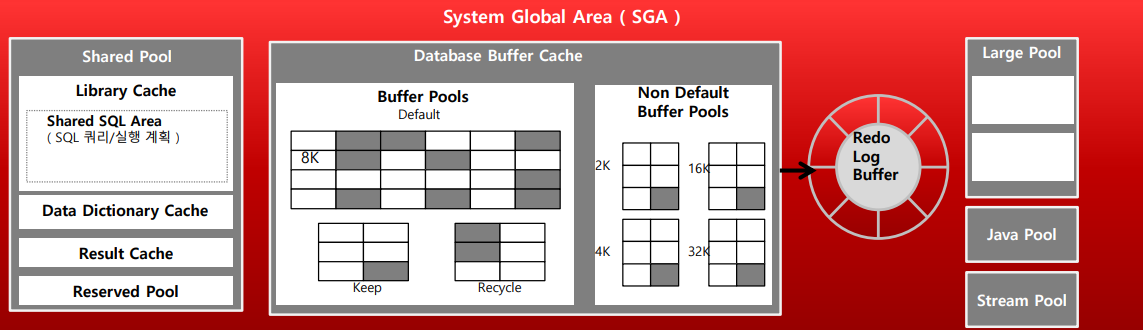

# **SGA 구성** (중요)
- 공유 풀(Shared Pool) : SQL 및 SQL 실행계획을 공유해서 같은 SQL의 Parsing은 권한 확인만 수행 하도록 만들어서 실행 속도를 높이도록 만든다. ( Data Dictionary Cache 를 활용해서 실행계획을 만들고 저장해서 공유. )
- 고정 영역(Permanent Area) : SGA를 관리하는 파라미터 정보
- 동적 영역(Dynamic Area) : 라이브러리 캐시(SQL, Parse Tree, 실행계획을 저장), 데이터 딕셔너리 캐시 (Oracle Object 정보를 저장)
- 데이터 버퍼 캐시 (Data Buffer Cache) : 디스크에서 읽어온 데이터를 저장하는 공간 (Disk I/O의 영향도를 줄이기 위해 Data File 의 Data Block을 메모리에 가져다 놓는다)
- 서버 프로세스 : 디스크 -> 데이터 버퍼 캐시 에로 데이터를 저장하는 프로세스

- DBWR(Database Writer) Background Process : 데이터 버퍼 캐시 -> 디스크로 데이터를 기록하는 프로세스

- LGWR (Log Writer) : 로그 버퍼의 내용을 로그 파일에 기록하는 프로세스 (Commit 수행 시, - DBWR에 의해 DIsk로 바로 기록되지 않고, Redo Log File에 기록해둔 뒤, 일괄적으로 Log File의 내용을 기준으로 Disk에 실제 데이터를 기록함, 유저 입장에서는 Commit 실행 시, Disk에 기록된 것으로 생각할 수 있음)

- Redo Log Buffer : 데이터 변경사항 ( DML 발생시) 정보를 가지며 Redo log file에 Write 되기 이전에 Memory에 먼저 Write 되는 영역

- Large Pool : Parallel Query 메시징 or 대용량의 메모리 할당이 필요한 경우 사용된다.

- Java Pool : Java Object에 대한 메모리 영역

- Stream Pool : Data 복제 등을 위한 Stream 사용 영역

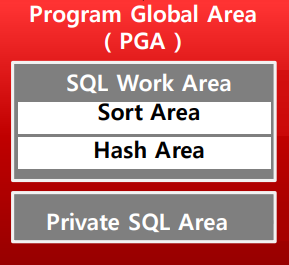

# **PGA 구성**

- 정렬 공간 (Sort Area) : Order by, Group by 수행 시 정렬할 때 사용되는 공간, 메모리 부족 시 디스크 공간 활용
- 세션 정보 (Session Information) : 서버 <-> 유저 연결 정보
- 커서 상태 정보(Cursor State) : SQL 파싱 정보가 저장되어 있는 주소
- 변수 저장 공간 (Stack Area) : Bind 변수를 저장하는 공간
- 유저 프로세스 -> 서버 프로세스 -> PGA로 할당

- SQL Work Area : 정렬에 관련된 작업 Sort by, Group by 같은 정렬이 필요할 경우 or Hash join 시 디스크 I/O를 감소
- Private SQL Area : SQL Runtime Memory Structure 로서 Cursor & Data Fetch 및 SQL 바인드 변수

# **메모리관리 개요**

- 사용가능한 메모리양의 한정
- 특정 유형의 기능을 제공하는 메모리를 더 많이 할당하면 전체적인 성능이 향상
- 자동으로 튜닝된 메모리여도 최적화를 위해 모니터 해야함. 어느정도 수동 구성 필요




# **메모리 구성 요소 관리**

**수동으로 구성하는 방법**
- 여러 개별 초기화 파라미터를 통해 구성 요소의 크기를 조정.
  - ex. Shared_pool_szie = 80m / db_cache_size = 40m

- 버전 기준 수동으로 구성하는 방법 : Dynamic SGA 기능
  - shared_pool_size=50m 으로 지정해 놨었는데 분석 보고서를 보니 Cache_hit가 적게 나오면,
  - 또는 DB_cahce_size 를 늘리거나 shared_pool_size를 늘리는 방법 존재

- 9g버전까지는 ref문서 63~64 처럼 수동으로 메모리 관리.


```sql
alter system set shared_pool_size = 50m;
db_cache_size
large_pool_size
alter system set log_buffer_20m scope=spfile; (DB Restart해야 적용가능)
```







**자동으로 구성하는 방법**

- 10g 버전부터 ASMM 자동화 버전이 나옴.

- 10g ASMM(자동 공유 메모리 관리): SGA
 -  하나의 초기화 파라미터를 통해 총 SGA 메모리를 지정할 수 있음.
 -  Oracle 서버가 Shared Pool, Java Pool, 버퍼 캐시, Streams Pool 및 Large Pool  할당된 메모리 양을 관리 할 수 있음.

-  sga_target 안에 Size를 지정할 수 있음.
-  sga_Max_size 가 sga_target_size 보다 크게 해야함.

  - ex)   sga_target_size = 1g 로 지정.

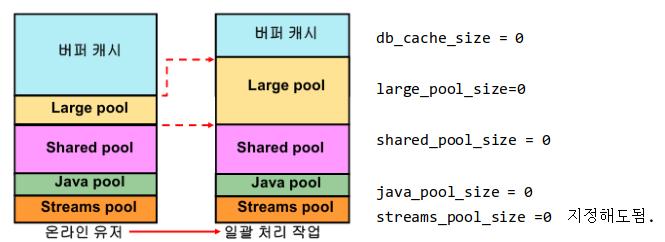

**ASMM 작동**

- Large pool 을 많이 사용하는 것이라면 자동으로 Large Pool 사이즈를 줄이고 다른 컴포넌트가 줄어들게 됨.
- 오라클 데이터베이스 서버가 메모리를 가장 효율적인 방식으로 활용하게 배분.
- 모든 파라미터 값을 0으로 지정하면 오라클에게 전적이로 맡김.
- shared_pool_size = 4 으로 지정하면 4 이하로는 떨어지지 않게 한다.

- 우리가 아는 log_buffer 는 무조건 지정한 값으로 설정됨.


**ASMM 이해**

- ASMM 은 MMON 이 백그라운드에서 캡처하는 작업로드 정보를 기반으로 작동

- MMON은 Memory Advisor 사용하여 주기적으로 캡처.

- MMAN 이 MMON의 결정에 따라 메모리 구성요소의 크기를 조정.

- 가장 많이 요구되는 곳으로 메모리 이동.

- SPFILE이 사용된 경우 컴퓨터 종료 후에도 구성요소 크기 저장



ASMM 활성화

수동 -> ASMM

 1. SGA_TARGET의 값을 가져온다

 2. 이 값을 사용하여 SGA_TARGET 값 설정

 3. 크기가 자동으로 조정되는 SGA 구성요소 값 0으로 설정





ASMM 비활성화

- SGA_TARGET을 0으로 설정.

 - ASMM 기능을 비활성화 하게 되면, 기능을 활성화 했을때 기준으로 값들이 설정되게 된다.







# **PGA 관리 (자동화)**

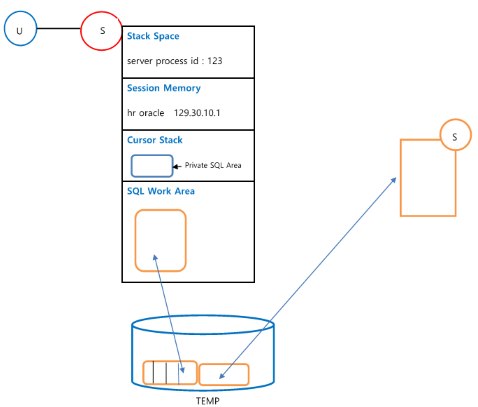

- pga_aggregate_target = 400m 로 설정을 하게 됨.
- 모든 서버들이 사용하는 PGA의 총량이 400m로 설정하는 것.



- **11g AMM(자동 메모리 관리) : sga + pga (sga와 pga의 통합)**
 - AMM 를 사용하여 instance에 할당되는 총 메모리를 지정할 수 있음

 - SGA 및 PGA 모두 포함한다.

-  자동 메모리 관리(AMM) 를 사용하면 데이터베이스 서버가 작업 로드에 따라 SGA / PGA 크기를 자동으로 조정.
-  memory_target = 을 설정한다. pga와 sga를 합친 사이즈를 지정하면 된다.
-  SGA와 PGA가 직접 주고 받는 것은 안된다. OS를 통해서 서로 부족한 부분을 받아낸다.



- AMM을 통해서 메모리를 자동화 하였다 해도



```sql
Log_buffer
Result_cache_size
DB_KEEP_CACHE_SIZE
DB_RECYVLE_CAHCE_SIZE
DB_nk_CACHE_SIZE 는 지정해줘야 한다.
```

- 이것을 먼저 지정해주고, Memort_target 지정하면 자동으로 저 부분을 할당후 나머지는 자동화 관리가 됨.



- 자동 메모리 관리를 확인하는 뷰
  - `V$MEMORY_DYNAMIC_COMPONENTS` : 모든 메모리 구성 요소의 현재 상태
  - `V$MEMORY_DYNAMIC_COMPONENTS` : 최근의 메모리 크기조정 요청의 순환 기록 버퍼
   - 요청이 많으면 사이즈가 작다. 그만큼 주었다 뺐는것이기 때문.



- **자동 PGA 메모리 관리 / 12c**

- Instance PGA 전용으로 사용되는 총 메모리 양을 전역적으로 자동 관리

- PGA_AGGREGATE_TARGET 파라미터를 사용하여 PGA 메모리 양 제어

  -  모든 서버 프로세스 및 BP에 할당된 총 PGA 메모리가 파라미터 값을 초과하지 않음
  -  목표 값이며 엄격한 한계는 아니다.



- PGA_AGGREGATE_LIMIT을 설정하지 않을 경우

  - PGA_AGGREGATE_TARGET의 200% or 400m로 지정됨